# DEF CON 27 AI Village
## Fighting Malware with Deep Learning
## Long-Short Term Memory Networks and Dynamic Analysis Data
### Angelo Oliveira @ang3loliveira
#### Datasets available at:
https://www.kaggle.com/ang3loliveira/malware-analysis-datasets-api-call-sequences

In [1]:
import numpy as np
np.random.seed(137)

import time
from collections import Counter
from IPython.display import Image
import pandas as pd

from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, CuDNNLSTM
from keras.utils import plot_model, to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline

Using TensorFlow backend.


## Data Preprocessing

In [2]:
df = pd.read_csv('api_call_sequences.csv')
df.head()

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_1015,t_1016,t_1017,t_1018,t_1019,t_1020,t_1021,t_1022,t_1023,malware
0,071e8c3f8922e186e57548cd4c703a5d,164,268,151,220,147,146,164,181,164,...,217,204,217,204,217,204,217,204,217,1
1,33f8e6d08a6aae939f25a8e0d63dd523,105,164,181,164,145,146,145,146,145,...,246,250,232,246,152,250,232,246,250,1
2,b68abd064e975e1c6d5f25e748663076,277,220,147,146,147,146,147,146,147,...,63,281,63,281,63,281,63,281,63,1
3,72049be7bd30ea61297ea624ae198067,105,164,181,164,145,146,145,146,145,...,63,281,63,281,63,281,63,281,63,1
4,c9b3700a77facf29172f32df6bc77f48,105,147,146,147,146,147,146,147,146,...,246,250,232,84,187,165,167,87,204,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47562 entries, 0 to 47561
Columns: 1026 entries, hash to malware
dtypes: int64(1025), object(1)
memory usage: 372.3+ MB


In [4]:
df.drop(['hash'], axis = 1, inplace = True)
df.head()

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_1015,t_1016,t_1017,t_1018,t_1019,t_1020,t_1021,t_1022,t_1023,malware
0,164,268,151,220,147,146,164,181,164,103,...,217,204,217,204,217,204,217,204,217,1
1,105,164,181,164,145,146,145,146,145,146,...,246,250,232,246,152,250,232,246,250,1
2,277,220,147,146,147,146,147,146,147,146,...,63,281,63,281,63,281,63,281,63,1
3,105,164,181,164,145,146,145,146,145,146,...,63,281,63,281,63,281,63,281,63,1
4,105,147,146,147,146,147,146,147,146,145,...,246,250,232,84,187,165,167,87,204,1


In [5]:
# Maximum number of instances supported by a computer with 32 GB RAM
X = df.values[:, 0:256].astype('uint16')
y = df.values[:, 1024].astype('uint8')
print(X.shape)
print(y.shape)
del df

(47562, 256)
(47562,)


In [6]:
def check_imbalance(dataset):
    count = sorted(Counter(dataset).items())
    print(count)
    print(count[1][1] / count[0][1])
    return

In [7]:
check_imbalance(y)

[(0, 1927), (1, 45635)]
23.68188894654904


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

del X
del y

In [9]:
check_imbalance(y_train)
check_imbalance(y_test)

[(0, 1357), (1, 31936)]
23.534266764922624
[(0, 570), (1, 13699)]
24.033333333333335


In [10]:
print(np.max(X_train))
print(np.max(X_test))

307
307


## Enter Deep Learning

In [11]:
def create_model(lstm_output = 128, dropout_rate = 0.1, batch_drop = False):
    model = Sequential()
    model.add(CuDNNLSTM(units = lstm_output, input_shape = (256, 308)))
    if batch_drop:
        model.add(BatchNormalization())
        model.add(Dropout(rate = dropout_rate))
    else:
        model.add(Dropout(rate = dropout_rate))
        model.add(BatchNormalization())
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    return model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 128)               224256    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 224,897
Trainable params: 224,641
Non-trainable params: 256
_________________________________________________________________


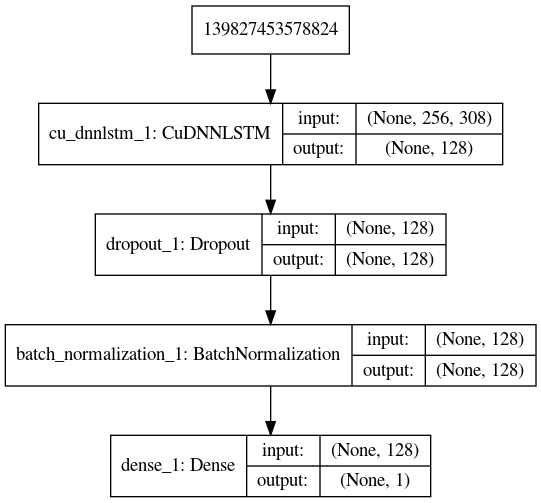

In [12]:
model = create_model()
model.summary()

plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)
del model
Image("model_plot.png")

## Model Selection

In [13]:
# Wrapper for Keras model to be used by the Pipeline
keras_classifier = KerasClassifier(
    build_fn = create_model,
    lstm_output = 128,
    dropout_rate = 0.1,
    batch_drop = False,
    epochs = 20,
    batch_size = 32,
    verbose = 1
)

# Reshaping for LSTM
def reshape_lstm(X):
    return to_categorical(X, num_classes = 308)

# Imbalanced Learn Pipeline
pipeline = Pipeline([
    ('ros', RandomOverSampler()),
    ('rl', FunctionTransformer(reshape_lstm, validate = False)),
    ('kc', keras_classifier)
])

# Hyperparameters
lstm_output = [128, 256, 512]
dropout_rate = [0.1, 0.4, 0.6]
batch_drop = [False, True]

# Grid search using 3-fold cross-validation and score function Balanced Accuracy
param_grid = dict(
    kc__lstm_output = lstm_output,
    kc__dropout_rate = dropout_rate,
    kc__batch_drop = batch_drop
)

grid = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    scoring = 'balanced_accuracy',
    n_jobs = 1
)

In [14]:
t0 = time.time()
grid.fit(X_train, y_train)
print('Training / CV time: %is' % (time.time() - t0))

/home/angelo/anaconda3/envs/deeplearning_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Instructions for updating:
Use tf.cast instead.
Epoch 1/20
42606/42606 [==============================] - 21s 503us/step - loss: 0.5835 - acc: 0.6883
Epoch 2/20
42606/42606 [==============================] - 19s 441us/step - loss: 0.5233 - acc: 0.7303
Epoch 3/20
42606/42606 [==============================] - 18s 425us/step - loss: 0.5022 - acc: 0.7431
Epoch 4/20
42606/42606 [==============================] - 18s 425us/step - loss: 0.4974 - acc: 0.7440
Epoch 5/20
42606/42606 [==============================] - 18s 425us/step - loss: 0.4636 - acc: 0.7651
Epoch 6/20
42606/42606 [==============================] - 18s 428us/step - loss: 0.4556 - acc: 0.7688
Epoch 7/20
42606/42606 [==============================] - 18s 428us/step - loss: 0.4316 - acc: 0.7931
Epoch 8/20
42606/42606 [==============================] - 18s 430us/step - loss: 0.4922 - acc: 0.7524
Epoch 9/20
42606/42606 [==============================] - 18s 429us/step - loss: 0.4631 - acc: 0.7667
Epoch 10/20
42606/42606 [=========

42558/42558 [==============================] - 33s 773us/step - loss: 0.0369 - acc: 0.9886
Epoch 14/20
42558/42558 [==============================] - 33s 771us/step - loss: 0.0331 - acc: 0.9898
Epoch 15/20
42558/42558 [==============================] - 33s 771us/step - loss: 0.0278 - acc: 0.9919
Epoch 16/20
42558/42558 [==============================] - 33s 774us/step - loss: 0.0232 - acc: 0.9934
Epoch 17/20
42558/42558 [==============================] - 33s 771us/step - loss: 0.0204 - acc: 0.9940
Epoch 18/20
42558/42558 [==============================] - 33s 769us/step - loss: 0.0197 - acc: 0.9942
Epoch 19/20
42558/42558 [==============================] - 33s 771us/step - loss: 0.0151 - acc: 0.9954
Epoch 20/20
11098/11098 [==============================] - 4s 362us/step
Epoch 1/20
42580/42580 [==============================] - 34s 797us/step - loss: 0.6014 - acc: 0.6742
Epoch 2/20
42580/42580 [==============================] - 33s 774us/step - loss: 0.5433 - acc: 0.7155
Epoch 3/20
425

42606/42606 [==============================] - 33s 779us/step - loss: 0.0926 - acc: 0.9710
Epoch 8/20
42606/42606 [==============================] - 33s 778us/step - loss: 0.3382 - acc: 0.8471
Epoch 9/20
42606/42606 [==============================] - 33s 778us/step - loss: 0.1817 - acc: 0.9324
Epoch 10/20
42606/42606 [==============================] - 33s 779us/step - loss: 0.1397 - acc: 0.9522
Epoch 11/20
42606/42606 [==============================] - 33s 780us/step - loss: 0.1198 - acc: 0.9599
Epoch 12/20
42606/42606 [==============================] - 33s 779us/step - loss: 0.0869 - acc: 0.9723
Epoch 13/20
42606/42606 [==============================] - 33s 779us/step - loss: 0.0711 - acc: 0.9777
Epoch 14/20
42606/42606 [==============================] - 33s 780us/step - loss: 0.0523 - acc: 0.9847
Epoch 15/20
42606/42606 [==============================] - 33s 779us/step - loss: 0.0433 - acc: 0.9881
Epoch 16/20
42606/42606 [==============================] - 33s 780us/step - loss: 0.035

42580/42580 [==============================] - 26s 609us/step - loss: 0.6652 - acc: 0.5970
Epoch 2/20
42580/42580 [==============================] - 24s 562us/step - loss: 0.6697 - acc: 0.5808
Epoch 3/20
42580/42580 [==============================] - 24s 563us/step - loss: 0.6229 - acc: 0.6527
Epoch 4/20
42580/42580 [==============================] - 24s 563us/step - loss: 0.6412 - acc: 0.6229
Epoch 5/20
42580/42580 [==============================] - 24s 562us/step - loss: 0.5889 - acc: 0.6863
Epoch 6/20
42580/42580 [==============================] - 24s 567us/step - loss: 0.6532 - acc: 0.6037
Epoch 7/20
42580/42580 [==============================] - 24s 557us/step - loss: 0.5814 - acc: 0.6930
Epoch 8/20
42580/42580 [==============================] - 24s 558us/step - loss: 0.4162 - acc: 0.8046
Epoch 9/20
42580/42580 [==============================] - 24s 564us/step - loss: 0.2869 - acc: 0.8826
Epoch 10/20
42580/42580 [==============================] - 24s 562us/step - loss: 0.1816 - ac

42606/42606 [==============================] - 24s 561us/step - loss: 0.0098 - acc: 0.9972
Epoch 17/20
42606/42606 [==============================] - 24s 560us/step - loss: 0.0091 - acc: 0.9976
Epoch 18/20
42606/42606 [==============================] - 24s 561us/step - loss: 0.0068 - acc: 0.9984
Epoch 19/20
42606/42606 [==============================] - 24s 560us/step - loss: 0.0096 - acc: 0.9973
Epoch 20/20
11098/11098 [==============================] - 4s 376us/step
Epoch 1/20
42558/42558 [==============================] - 27s 625us/step - loss: 0.5848 - acc: 0.6871
Epoch 2/20
42558/42558 [==============================] - 24s 562us/step - loss: 0.5306 - acc: 0.7278
Epoch 3/20
42558/42558 [==============================] - 24s 562us/step - loss: 0.5023 - acc: 0.7440
Epoch 4/20
42558/42558 [==============================] - 24s 563us/step - loss: 0.5008 - acc: 0.7447
Epoch 5/20
42558/42558 [==============================] - 24s 562us/step - loss: 0.4861 - acc: 0.7548
Epoch 6/20
42558/

42580/42580 [==============================] - 20s 468us/step - loss: 0.0733 - acc: 0.9789
Epoch 11/20
42580/42580 [==============================] - 20s 467us/step - loss: 0.0690 - acc: 0.9806
Epoch 12/20
42580/42580 [==============================] - 20s 468us/step - loss: 0.0620 - acc: 0.9816
Epoch 13/20
42580/42580 [==============================] - 20s 467us/step - loss: 0.0417 - acc: 0.9885
Epoch 14/20
42580/42580 [==============================] - 20s 468us/step - loss: 0.0551 - acc: 0.9838
Epoch 15/20
42580/42580 [==============================] - 20s 467us/step - loss: 0.0609 - acc: 0.9833
Epoch 16/20
42580/42580 [==============================] - 20s 468us/step - loss: 0.0338 - acc: 0.9908
Epoch 17/20
42580/42580 [==============================] - 20s 467us/step - loss: 0.0354 - acc: 0.9899
Epoch 18/20
42580/42580 [==============================] - 20s 467us/step - loss: 0.0413 - acc: 0.9886
Epoch 19/20
42580/42580 [==============================] - 20s 468us/step - loss: 0.0

42558/42558 [==============================] - 20s 478us/step - loss: 0.1859 - acc: 0.9364
Epoch 5/20
42558/42558 [==============================] - 20s 478us/step - loss: 0.1291 - acc: 0.9583
Epoch 6/20
42558/42558 [==============================] - 20s 478us/step - loss: 0.1045 - acc: 0.9674
Epoch 7/20
42558/42558 [==============================] - 20s 477us/step - loss: 0.0838 - acc: 0.9741
Epoch 8/20
42558/42558 [==============================] - 20s 478us/step - loss: 0.0669 - acc: 0.9797
Epoch 9/20
42558/42558 [==============================] - 20s 477us/step - loss: 0.0583 - acc: 0.9830
Epoch 10/20
42558/42558 [==============================] - 20s 477us/step - loss: 0.0437 - acc: 0.9884
Epoch 11/20
42558/42558 [==============================] - 20s 478us/step - loss: 0.0396 - acc: 0.9890
Epoch 12/20
42558/42558 [==============================] - 20s 478us/step - loss: 0.0369 - acc: 0.9899
Epoch 13/20
42558/42558 [==============================] - 20s 477us/step - loss: 0.0272 -

42580/42580 [==============================] - 35s 828us/step - loss: 0.0085 - acc: 0.9976
Epoch 20/20
11097/11097 [==============================] - 6s 577us/step
Epoch 1/20
63872/63872 [==============================] - 58s 903us/step - loss: 0.6420 - acc: 0.6329
Epoch 2/20
63872/63872 [==============================] - 53s 826us/step - loss: 0.3948 - acc: 0.8148
Epoch 3/20
63872/63872 [==============================] - 53s 826us/step - loss: 0.1841 - acc: 0.9326
Epoch 4/20
63872/63872 [==============================] - 53s 826us/step - loss: 0.1130 - acc: 0.9628
Epoch 5/20
63872/63872 [==============================] - 53s 826us/step - loss: 0.0721 - acc: 0.9785
Epoch 6/20
63872/63872 [==============================] - 53s 826us/step - loss: 0.0489 - acc: 0.9866
Epoch 7/20
63872/63872 [==============================] - 53s 826us/step - loss: 0.0359 - acc: 0.9903
Epoch 8/20
63872/63872 [==============================] - 53s 826us/step - loss: 0.0287 - acc: 0.9929
Epoch 9/20
63872/638

In [15]:
def grid_results(model):
    print("Best: %.4f using %s" % (model.best_score_, model.best_params_))
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%.4f (%.4f) with: %r" % (mean, stdev, param))

In [16]:
def model_evaluate(y, pred):
    print('Confusion matrix\n[TN FP]\n[FN TP]')
    print(confusion_matrix(y, pred))
    print('Accuracy: %.4f' % (accuracy_score(y, pred)))    
    print('Precision: %.4f' % (precision_score(y, pred)))    
    print('Recall: %.4f' % (recall_score(y, pred)))
    print('F1-Score: %.4f' % (f1_score(y, pred)))    
    print('Balanced Accuracy (ROC AUC): %.4f' % (balanced_accuracy_score(y, pred)))
    return

In [17]:
# Fully connected layer: Dropout than Batchnorm, LSMT output maximum size
grid_results(grid)

Best: 0.9227 using {'kc__batch_drop': False, 'kc__dropout_rate': 0.4, 'kc__lstm_output': 512}
0.7850 (0.1084) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.1, 'kc__lstm_output': 128}
0.9099 (0.0104) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.1, 'kc__lstm_output': 256}
0.8920 (0.0166) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.1, 'kc__lstm_output': 512}
0.7506 (0.1473) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.4, 'kc__lstm_output': 128}
0.9119 (0.0309) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.4, 'kc__lstm_output': 256}
0.9227 (0.0022) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.4, 'kc__lstm_output': 512}
0.8721 (0.0474) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.6, 'kc__lstm_output': 128}
0.8263 (0.1109) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.6, 'kc__lstm_output': 256}
0.9174 (0.0065) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.6, 'kc__lstm_output': 512}
0.8335 (0.0414) with: {'kc__batch

## Evaluation

In [18]:
model_evaluate(y_test, np.ones(y_test.shape))

Confusion matrix
[TN FP]
[FN TP]
[[    0   570]
 [    0 13699]]
Accuracy: 0.9601
Precision: 0.9601
Recall: 1.0000
F1-Score: 0.9796
Balanced Accuracy (ROC AUC): 0.5000


In [19]:
model_evaluate(y_test, grid.predict(X_test))

14269/14269 [==============================] - 8s 543us/step
Confusion matrix
[TN FP]
[FN TP]
[[  480    90]
 [   89 13610]]
Accuracy: 0.9875
Precision: 0.9934
Recall: 0.9935
F1-Score: 0.9935
Balanced Accuracy (ROC AUC): 0.9178
